# Importing Libraries

In [1]:
import dlib
import cv2
import os
import re
import json
from pylab import *
from PIL import Image, ImageChops, ImageEnhance
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import splitfolders
import PIL
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
import glob
import cv2
import seaborn as sns
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization, LSTM
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, ResNet50
from tensorflow.keras.layers import Input, Flatten, Dense, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os, shutil
import sys
import shutil
import glob as gb
import warnings
warnings.filterwarnings('ignore')

# Preparing the dataset

In [2]:
real_videos_folder = 'Dataset/Real'
fake_videos_folder = 'Dataset/Fake'

def process_videos(video_folder, output_folder):
    list_of_data = [f for f in os.listdir(video_folder) if f.endswith('.mp4')]
    detector = dlib.get_frontal_face_detector()

    for vid in list_of_data:
        count = 0
        cap = cv2.VideoCapture(os.path.join(video_folder, vid))
        frameRate = cap.get(5)

        while cap.isOpened():
            frameId = cap.get(1)
            ret, frame = cap.read()

            if not ret or frame is None or frame.size == 0:
                break

            if frameId % ((int(frameRate) + 1) * 1) == 0:
                face_rects, _, _ = detector.run(frame, 0)
                
                for i, d in enumerate(face_rects):
                    x1 = d.left()
                    y1 = d.top()
                    x2 = d.right()
                    y2 = d.bottom()
                    crop_img = frame[y1:y2, x1:x2]

                    if crop_img.size != 0:
                        resized_img = cv2.resize(crop_img, (128, 128))
                        cv2.imwrite(os.path.join(output_folder, vid.split('.')[0] + '_' + str(count) + '.png'), resized_img)
                        count += 1

In [3]:
process_videos(real_videos_folder, 'data/real')

In [4]:
process_videos(fake_videos_folder, 'data/fake')

# Loading the dataset

In [5]:

class config:
    
    data_path = 'data/'
    
    path_train = "./output/train"
    path_test = "./output/test"

In [6]:
splitfolders.ratio(config.data_path, output="output", seed=101, ratio=(.8, .2))

Copying files: 9814 files [00:04, 2055.28 files/s]


# EDA

In [7]:
BATCH_SIZE = 64
IMAGE_SHAPE = (128, 128)

In [8]:
TRAIN_PATH = "output/train"
VAL_PATH = "output/val"

In [9]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

train_gen = datagen.flow_from_directory(directory = TRAIN_PATH, 
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

val_gen = datagen.flow_from_directory(directory = VAL_PATH, 
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

Found 7850 images belonging to 2 classes.
Found 1964 images belonging to 2 classes.


# Data Visualization

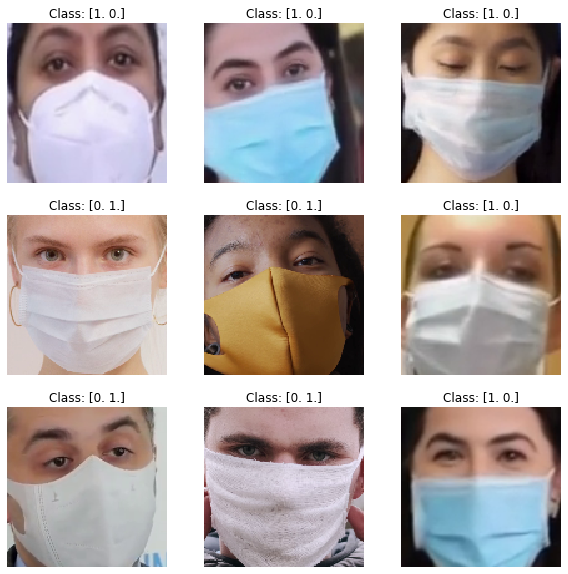

In [10]:
def plot_images(generator, num_images=9):
    
    images, labels = generator.next()

    
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f'Class: {labels[i]}')
        plt.axis('off')
    
    plt.show()


plot_images(train_gen)



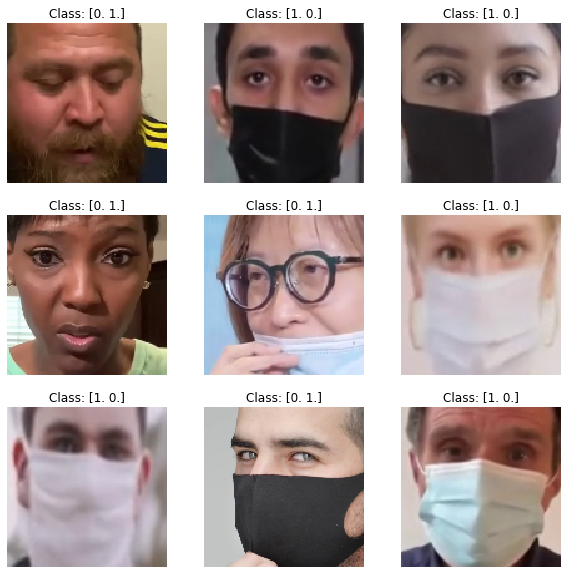

In [11]:
plot_images(val_gen)

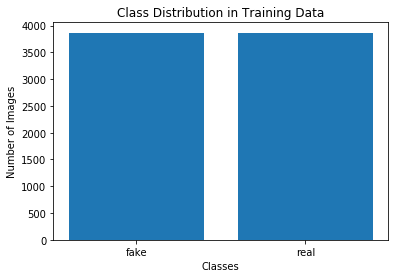

In [12]:
class_counts = np.sum(train_gen.labels, axis=0)
classes = list(train_gen.class_indices.keys())

plt.bar(classes, class_counts)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Training Data')
plt.show()

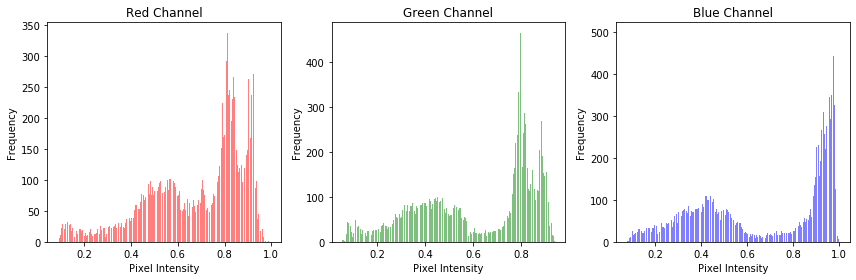

In [13]:
def plot_pixel_intensity(image):
    plt.figure(figsize=(12, 4))

   
    plt.subplot(1, 3, 1)
    plt.hist(image[:, :, 0].ravel(), bins=256, color='red', alpha=0.5, rwidth=0.8)
    plt.title('Red Channel')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    
    plt.subplot(1, 3, 2)
    plt.hist(image[:, :, 1].ravel(), bins=256, color='green', alpha=0.5, rwidth=0.8)
    plt.title('Green Channel')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    
    plt.subplot(1, 3, 3)
    plt.hist(image[:, :, 2].ravel(), bins=256, color='blue', alpha=0.5, rwidth=0.8)
    plt.title('Blue Channel')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()


sample_image = train_gen[0][0][0]  
plot_pixel_intensity(sample_image)

# Model Building

### Inception-ResNet-v2

In [14]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

In [15]:
inc = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(128, 128, 3), pooling='max')


x31 = Flatten()(inc.output)
predictionss = Dense(2, activation='softmax')(x31)


model = Model(inputs = inc.inputs, outputs = predictionss)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [16]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m, mae, mse])
history = model.fit(train_gen, validation_data=val_gen, epochs=50, steps_per_epoch=len(train_gen), validation_steps=len(val_gen), callbacks=[early_stopping_callback])

Epoch 1/50
123/123 [==============================] - 42s 236ms/step - loss: 0.3948 - accuracy: 0.9037 - f1_score: 0.9040 - recall_m: 0.9040 - precision_m: 0.9040 - specificity_m: 0.9040 - sensitivity_m: 0.9040 - mae: 0.1419 - mse: 0.0743 - val_loss: 0.2778 - val_accuracy: 0.9430 - val_f1_score: 0.9433 - val_recall_m: 0.9433 - val_precision_m: 0.9433 - val_specificity_m: 0.9433 - val_sensitivity_m: 0.9433 - val_mae: 0.0856 - val_mse: 0.0475
Epoch 2/50
123/123 [==============================] - 10s 82ms/step - loss: 0.1733 - accuracy: 0.9661 - f1_score: 0.9662 - recall_m: 0.9662 - precision_m: 0.9662 - specificity_m: 0.9662 - sensitivity_m: 0.9662 - mae: 0.0525 - mse: 0.0280 - val_loss: 3.4956 - val_accuracy: 0.9603 - val_f1_score: 0.9602 - val_recall_m: 0.9602 - val_precision_m: 0.9602 - val_specificity_m: 0.9602 - val_sensitivity_m: 0.9602 - val_mae: 0.0494 - val_mse: 0.0315
Epoch 3/50
123/123 [==============================] - 10s 79ms/step - loss: 0.0941 - accuracy: 0.9752 - f1_scor

In [17]:
model.save('models/Inceptionresnet_v2.h5')

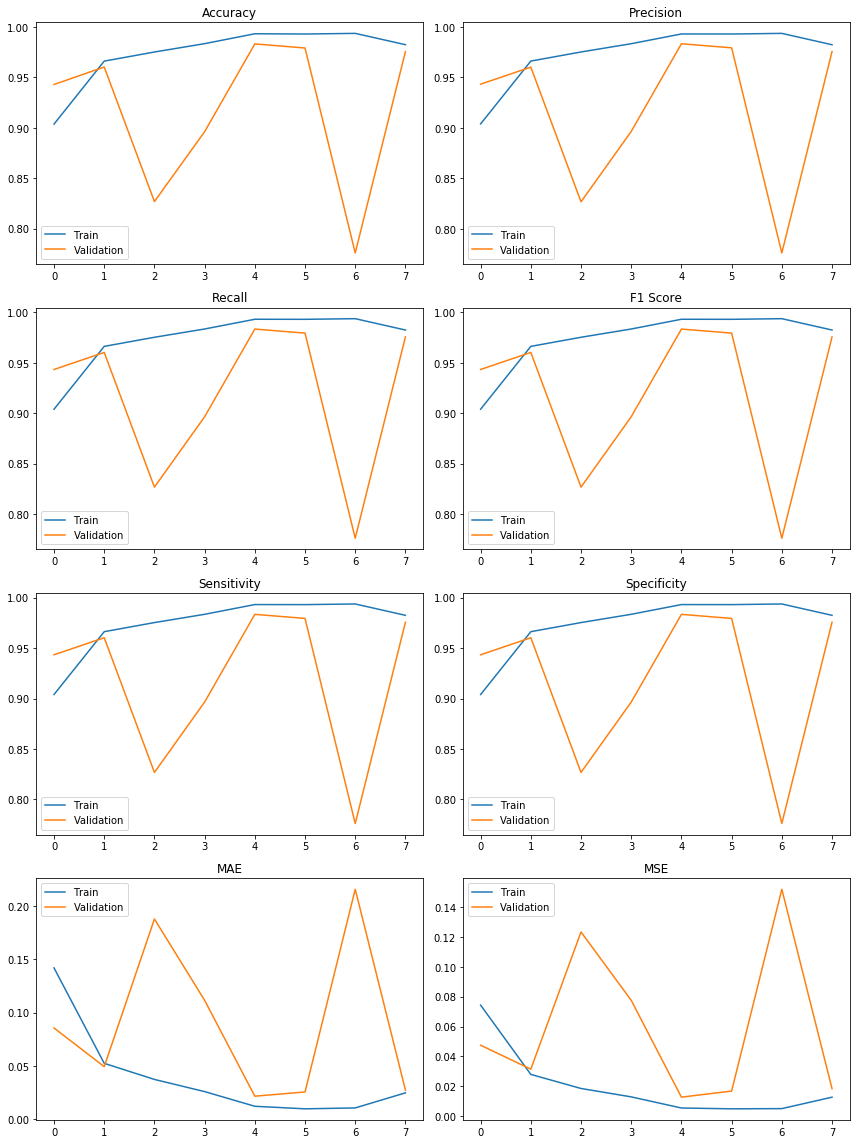

In [18]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

31/31 [==============================] - 1s 38ms/step - loss: 0.0741 - accuracy: 0.9756 - f1_score: 0.9756 - recall_m: 0.9756 - precision_m: 0.9756 - specificity_m: 0.9756 - sensitivity_m: 0.9756 - mae: 0.0274 - mse: 0.0185


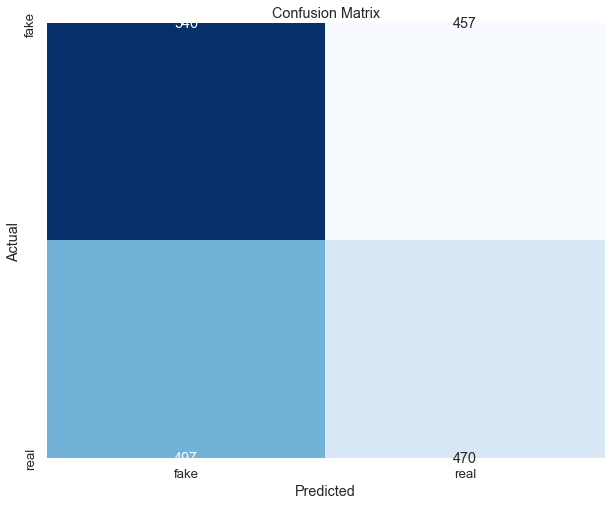

In [19]:
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [20]:
a = history.history['accuracy'][-1]
f = history.history['f1_score'][-1]
p = history.history['precision_m'][-1]
r = history.history['recall_m'][-1]
mae = history.history['mae'][-1]
mse = history.history['mse'][-1]
specificity = history.history['specificity_m'][-1]  
sensitivity = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a * 100))
print('Precision = ' + str(p * 100))
print('F1 Score = ' + str(f * 100))
print('Recall = ' + str(r * 100))
print('MAE = ' + str(mae))
print('MSE = ' + str(mse))
print('Sensitivity = ' + str(sensitivity * 100))  
print('Specificity = ' + str(specificity * 100))

Accuracy = 98.24203848838806
Precision = 98.24029803276062
F1 Score = 98.24029803276062
Recall = 98.24029803276062
MAE = 0.024855980649590492
MSE = 0.012803812511265278
Sensitivity = 98.24029803276062
Specificity = 98.24029803276062


# VGG19

In [21]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

In [22]:
inc = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=(128, 128, 3), pooling='max')


x31 = Flatten()(inc.output)
predictionss = Dense(2, activation='softmax')(x31)


model = Model(inputs = inc.inputs, outputs = predictionss)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [23]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m, mae, mse])
history = model.fit(train_gen, validation_data=val_gen, epochs=50, steps_per_epoch=len(train_gen), validation_steps=len(val_gen), callbacks=[early_stopping_callback])

Epoch 1/50
123/123 [==============================] - 10s 69ms/step - loss: 1.4756 - accuracy: 0.4982 - f1_score: 0.4985 - recall_m: 0.4985 - precision_m: 0.4985 - specificity_m: 0.4985 - sensitivity_m: 0.4985 - mae: 0.4997 - mse: 0.2599 - val_loss: 0.6933 - val_accuracy: 0.4924 - val_f1_score: 0.4929 - val_recall_m: 0.4929 - val_precision_m: 0.4929 - val_specificity_m: 0.4929 - val_sensitivity_m: 0.4929 - val_mae: 0.5001 - val_mse: 0.2501
Epoch 2/50
123/123 [==============================] - 7s 55ms/step - loss: 0.6948 - accuracy: 0.4992 - f1_score: 0.4992 - recall_m: 0.4992 - precision_m: 0.4992 - specificity_m: 0.4992 - sensitivity_m: 0.4992 - mae: 0.4997 - mse: 0.2508 - val_loss: 0.6935 - val_accuracy: 0.4924 - val_f1_score: 0.4913 - val_recall_m: 0.4913 - val_precision_m: 0.4913 - val_specificity_m: 0.4913 - val_sensitivity_m: 0.4913 - val_mae: 0.5000 - val_mse: 0.2502
Epoch 3/50
123/123 [==============================] - 7s 55ms/step - loss: 0.6944 - accuracy: 0.5162 - f1_score: 

In [24]:
model.save('models/vgg19.h5')

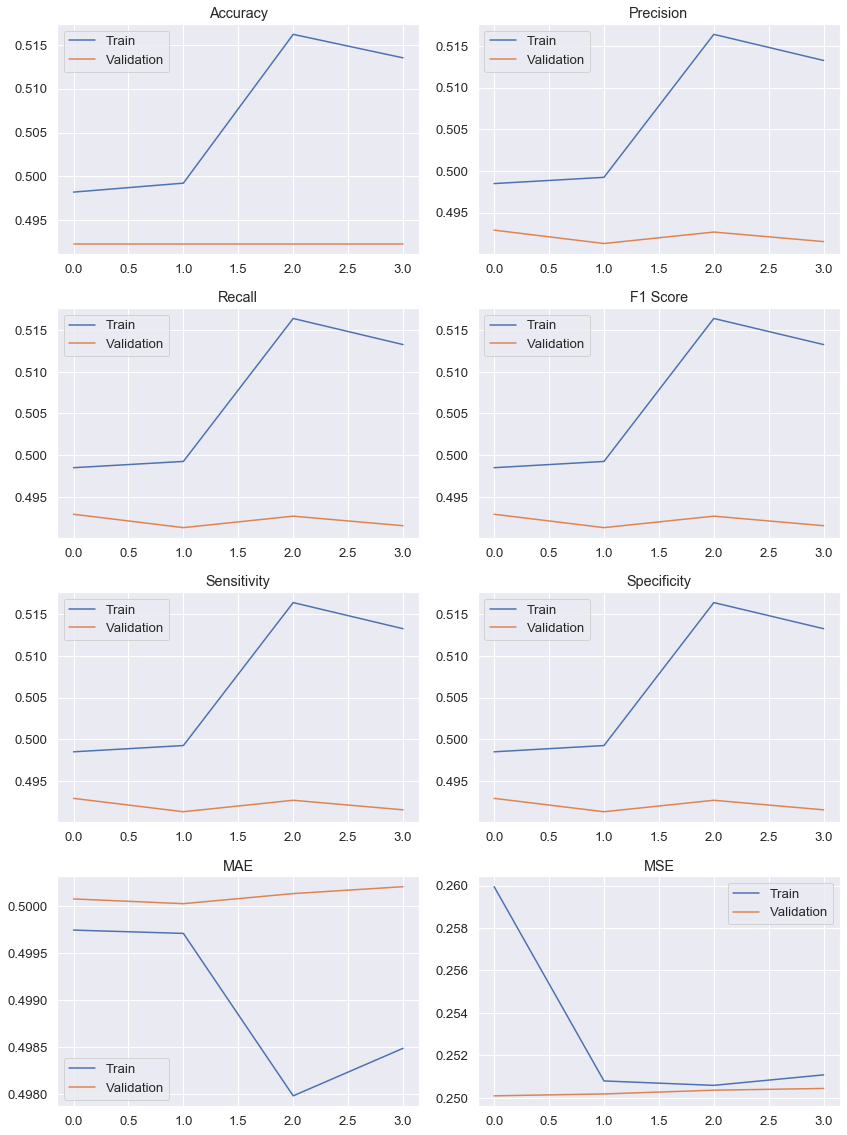

In [25]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

31/31 [==============================] - 1s 34ms/step - loss: 0.6940 - accuracy: 0.4924 - f1_score: 0.4929 - recall_m: 0.4929 - precision_m: 0.4929 - specificity_m: 0.4929 - sensitivity_m: 0.4929 - mae: 0.5002 - mse: 0.2504


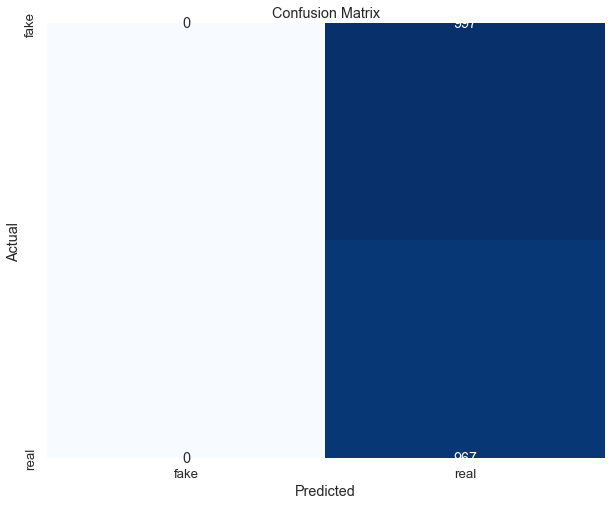

In [26]:
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [27]:
a1 = history.history['accuracy'][-1]
f1 = history.history['f1_score'][-1]
p1 = history.history['precision_m'][-1]
r1 = history.history['recall_m'][-1]
mae1 = history.history['mae'][-1]
mse1 = history.history['mse'][-1]
specificity1 = history.history['specificity_m'][-1]  
sensitivity1 = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a1 * 100))
print('Precision = ' + str(p1 * 100))
print('F1 Score = ' + str(f1 * 100))
print('Recall = ' + str(r1 * 100))
print('MAE = ' + str(mae1))
print('MSE = ' + str(mse1))
print('Sensitivity = ' + str(sensitivity1 * 100))  
print('Specificity = ' + str(specificity1 * 100))

Accuracy = 51.350319385528564
Precision = 51.326584815979004
F1 Score = 51.326578855514526
Recall = 51.326584815979004
MAE = 0.4984888732433319
MSE = 0.2510802745819092
Sensitivity = 51.326584815979004
Specificity = 51.326584815979004


# CNN

In [28]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred)) 

In [29]:
model = models.Sequential() 


model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=[128, 128, 3]))
model.add(MaxPooling2D(2, ))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2))


model.add(Flatten())


model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_203 (Conv2D)          (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_204 (Conv2D)          (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8388736   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [30]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m, mae, mse])
history = model.fit(train_gen, validation_data=val_gen, epochs=50, steps_per_epoch=len(train_gen), validation_steps=len(val_gen), callbacks=[early_stopping_callback])

Epoch 1/50
123/123 [==============================] - 6s 45ms/step - loss: 0.5093 - accuracy: 0.7517 - f1_score: 0.7520 - recall_m: 0.7520 - precision_m: 0.7520 - specificity_m: 0.7520 - sensitivity_m: 0.7520 - mae: 0.3306 - mse: 0.1654 - val_loss: 0.3166 - val_accuracy: 0.8758 - val_f1_score: 0.8768 - val_recall_m: 0.8768 - val_precision_m: 0.8768 - val_specificity_m: 0.8768 - val_sensitivity_m: 0.8768 - val_mae: 0.1910 - val_mse: 0.0953
Epoch 2/50
123/123 [==============================] - 5s 43ms/step - loss: 0.2868 - accuracy: 0.8852 - f1_score: 0.8853 - recall_m: 0.8853 - precision_m: 0.8853 - specificity_m: 0.8853 - sensitivity_m: 0.8853 - mae: 0.1818 - mse: 0.0872 - val_loss: 0.2482 - val_accuracy: 0.9084 - val_f1_score: 0.9084 - val_recall_m: 0.9084 - val_precision_m: 0.9084 - val_specificity_m: 0.9084 - val_sensitivity_m: 0.9084 - val_mae: 0.1448 - val_mse: 0.0715
Epoch 3/50
123/123 [==============================] - 5s 43ms/step - loss: 0.2216 - accuracy: 0.9162 - f1_score: 0

In [31]:
model.save('models/cnn.h5')

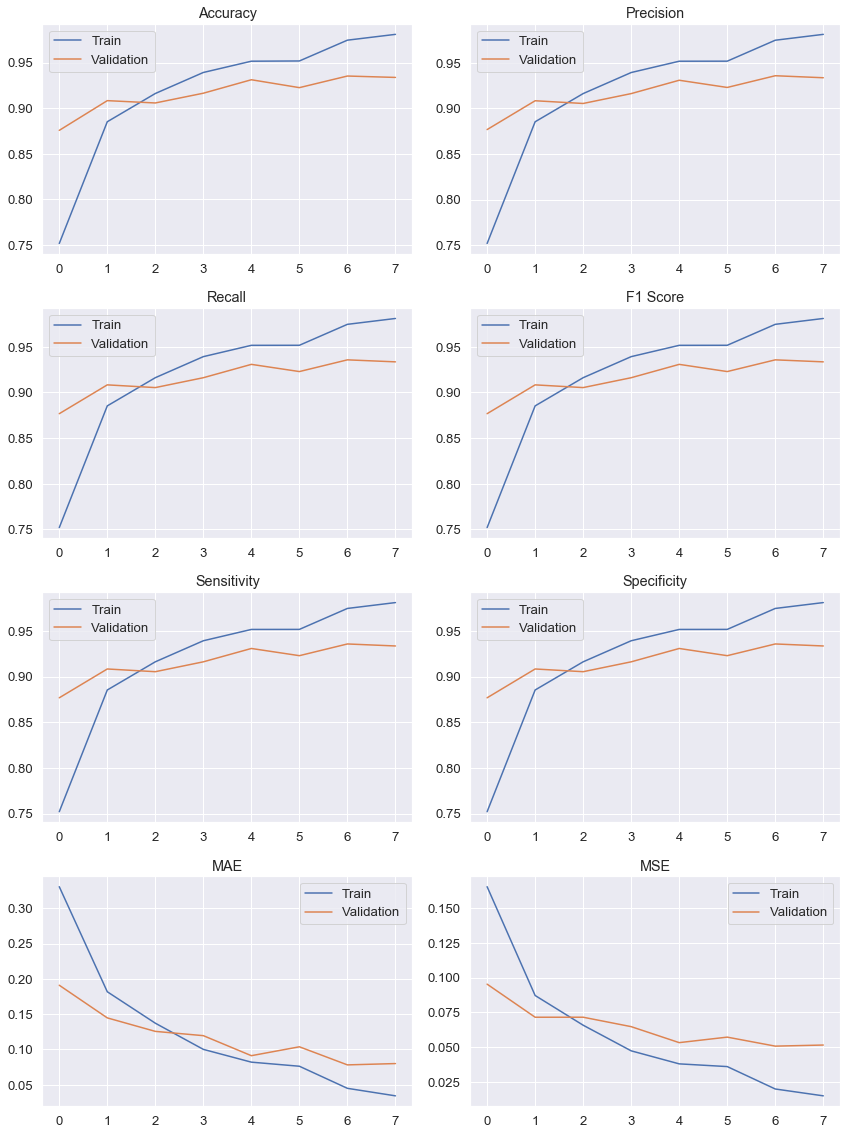

In [32]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

31/31 [==============================] - 1s 34ms/step - loss: 0.2101 - accuracy: 0.9338 - f1_score: 0.9338 - recall_m: 0.9338 - precision_m: 0.9338 - specificity_m: 0.9338 - sensitivity_m: 0.9338 - mae: 0.0800 - mse: 0.0515


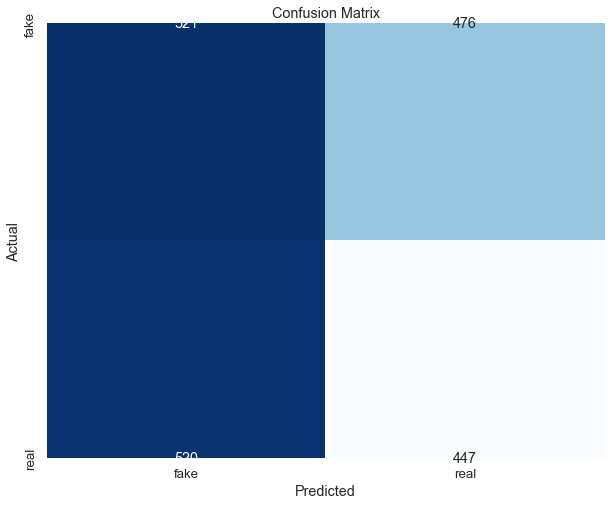

In [33]:
# Evaluate the model on the validation data
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes

# Retrieve class labels (class names) from the generator
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [34]:
a2 = history.history['accuracy'][-1]
f2 = history.history['f1_score'][-1]
p2 = history.history['precision_m'][-1]
r2 = history.history['recall_m'][-1]
mae2 = history.history['mae'][-1]
mse2 = history.history['mse'][-1]
specificity2 = history.history['specificity_m'][-1]  
sensitivity2 = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a2 * 100))
print('Precision = ' + str(p2 * 100))
print('F1 Score = ' + str(f2 * 100))
print('Recall = ' + str(r2 * 100))
print('MAE = ' + str(mae2))
print('MSE = ' + str(mse2))
print('Sensitivity = ' + str(sensitivity2 * 100))  
print('Specificity = ' + str(specificity2 * 100))

Accuracy = 98.10190796852112
Precision = 98.10721278190613
F1 Score = 98.10721278190613
Recall = 98.10721278190613
MAE = 0.03428848460316658
MSE = 0.015010216273367405
Sensitivity = 98.10721278190613
Specificity = 98.10721278190613


# Xception

In [35]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred)) 

In [36]:
inc = tf.keras.applications.xception.Xception(include_top=False, weights='imagenet', input_shape=(128, 128, 3), pooling='max')


x31 = Flatten()(inc.output)
predictionss = Dense(2, activation='softmax')(x31)


model = Model(inputs = inc.inputs, outputs = predictionss)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [37]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m, mae, mse])
history = model.fit(train_gen, validation_data=val_gen, epochs=50, steps_per_epoch=len(train_gen), validation_steps=len(val_gen), callbacks=[early_stopping_callback])

Epoch 1/50
123/123 [==============================] - 14s 95ms/step - loss: 0.3522 - accuracy: 0.8315 - f1_score: 0.8309 - recall_m: 0.8309 - precision_m: 0.8309 - specificity_m: 0.8309 - sensitivity_m: 0.8309 - mae: 0.2308 - mse: 0.1153 - val_loss: 0.3099 - val_accuracy: 0.9470 - val_f1_score: 0.9474 - val_recall_m: 0.9474 - val_precision_m: 0.9474 - val_specificity_m: 0.9474 - val_sensitivity_m: 0.9474 - val_mae: 0.0550 - val_mse: 0.0478
Epoch 2/50
123/123 [==============================] - 11s 89ms/step - loss: 0.0831 - accuracy: 0.9720 - f1_score: 0.9720 - recall_m: 0.9720 - precision_m: 0.9720 - specificity_m: 0.9720 - sensitivity_m: 0.9720 - mae: 0.0451 - mse: 0.0219 - val_loss: 0.6079 - val_accuracy: 0.8106 - val_f1_score: 0.8114 - val_recall_m: 0.8114 - val_precision_m: 0.8114 - val_specificity_m: 0.8114 - val_sensitivity_m: 0.8114 - val_mae: 0.1805 - val_mse: 0.1287
Epoch 3/50
123/123 [==============================] - 11s 91ms/step - loss: 0.0492 - accuracy: 0.9831 - f1_score

In [38]:
model.save('models/Xception.h5')

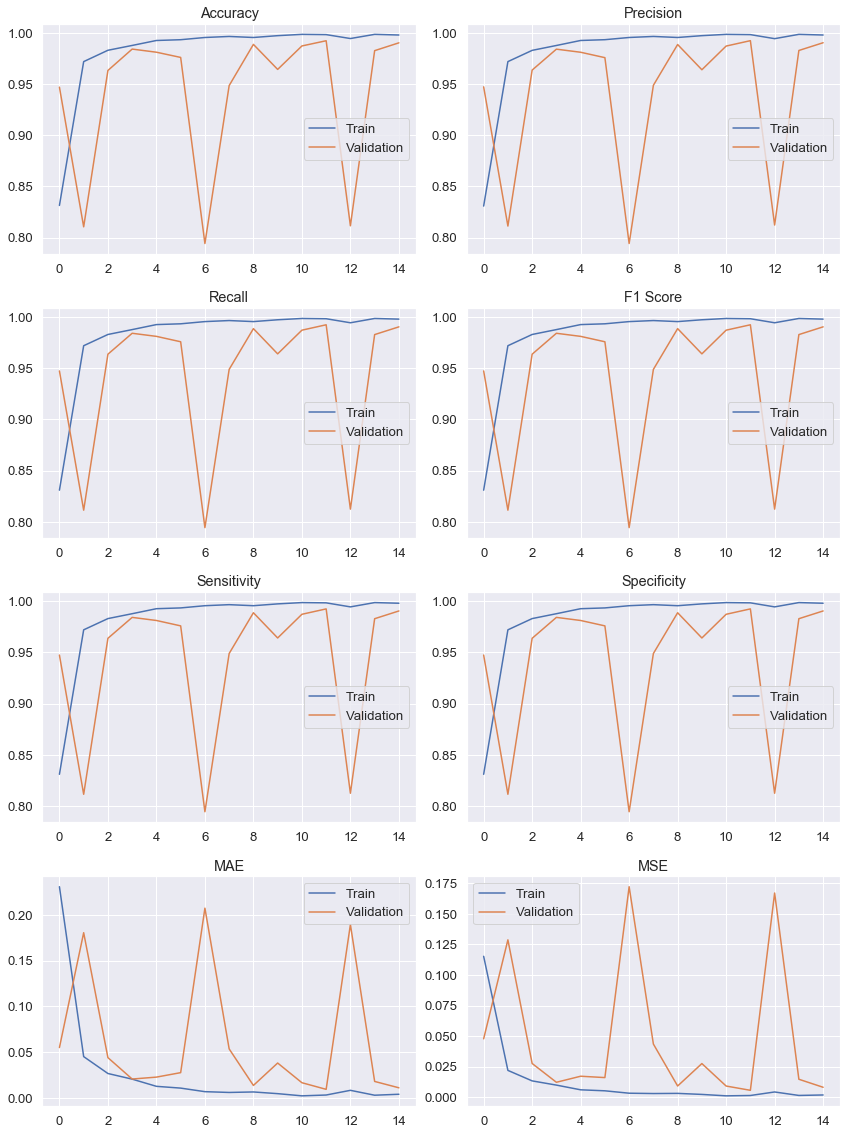

In [39]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

31/31 [==============================] - 1s 35ms/step - loss: 0.0387 - accuracy: 0.9903 - f1_score: 0.9904 - recall_m: 0.9904 - precision_m: 0.9904 - specificity_m: 0.9904 - sensitivity_m: 0.9904 - mae: 0.0110 - mse: 0.0081


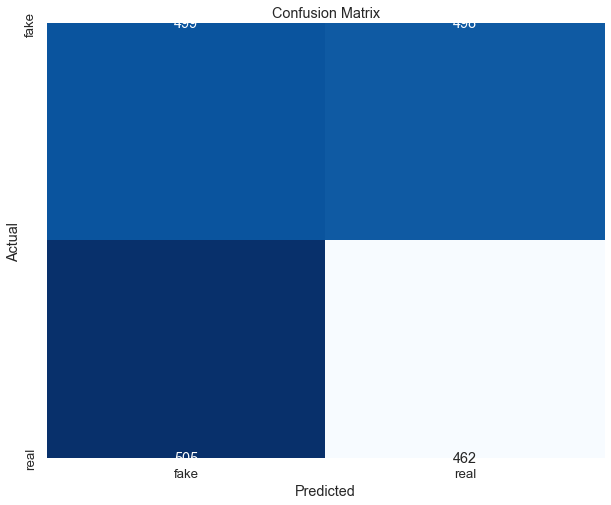

In [40]:
# Evaluate the model on the validation data
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes

# Retrieve class labels (class names) from the generator
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [41]:
a3 = history.history['accuracy'][-1]
f3 = history.history['f1_score'][-1]
p3 = history.history['precision_m'][-1]
r3 = history.history['recall_m'][-1]
mae3 = history.history['mae'][-1]
mse3 = history.history['mse'][-1]
specificity3 = history.history['specificity_m'][-1]  
sensitivity3 = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a3 * 100))
print('Precision = ' + str(p3 * 100))
print('F1 Score = ' + str(f3 * 100))
print('Recall = ' + str(r3 * 100))
print('MAE = ' + str(mae3))
print('MSE = ' + str(mse3))
print('Sensitivity = ' + str(sensitivity3 * 100))  
print('Specificity = ' + str(specificity3 * 100))

Accuracy = 99.79617595672607
Precision = 99.79674816131592
F1 Score = 99.79674816131592
Recall = 99.79674816131592
MAE = 0.004014241974800825
MSE = 0.0017973643261939287
Sensitivity = 99.79674816131592
Specificity = 99.79674816131592


# Comparison

In [42]:
results ={'Accuracy': [a,a1,a2,a3],
 'Recall':[r,r1,r2,r3],
 'Precision': [p,p1,p2,p3],
  'F1 Score' : [f,f1,f2,f3],
    'Sensitivity' : [sensitivity,sensitivity1,sensitivity2,sensitivity3],
    'Specificity' : [specificity,specificity1,specificity2,specificity3],
   'MAE' : [mae,mae1,mae2,mae3],
    'MSE' : [mse,mse1,mse2,mse3]}
index = ['InceptionResnet V2','VGG19','CNN','Xception']

In [43]:
results =pd.DataFrame(results,index=index)

In [44]:
print(results)

                    Accuracy    Recall  Precision  F1 Score  Sensitivity  \
InceptionResnet V2  0.982420  0.982403   0.982403  0.982403     0.982403   
VGG19               0.513503  0.513266   0.513266  0.513266     0.513266   
CNN                 0.981019  0.981072   0.981072  0.981072     0.981072   
Xception            0.997962  0.997967   0.997967  0.997967     0.997967   

                    Specificity                                   MAE  \
InceptionResnet V2     0.982403  <function mae at 0x0000026655CCF438>   
VGG19                  0.513266                              0.498489   
CNN                    0.981072                             0.0342885   
Xception               0.997967                            0.00401424   

                                                     MSE  
InceptionResnet V2  <function mse at 0x0000026655CCF558>  
VGG19                                            0.25108  
CNN                                            0.0150102  
Xception         

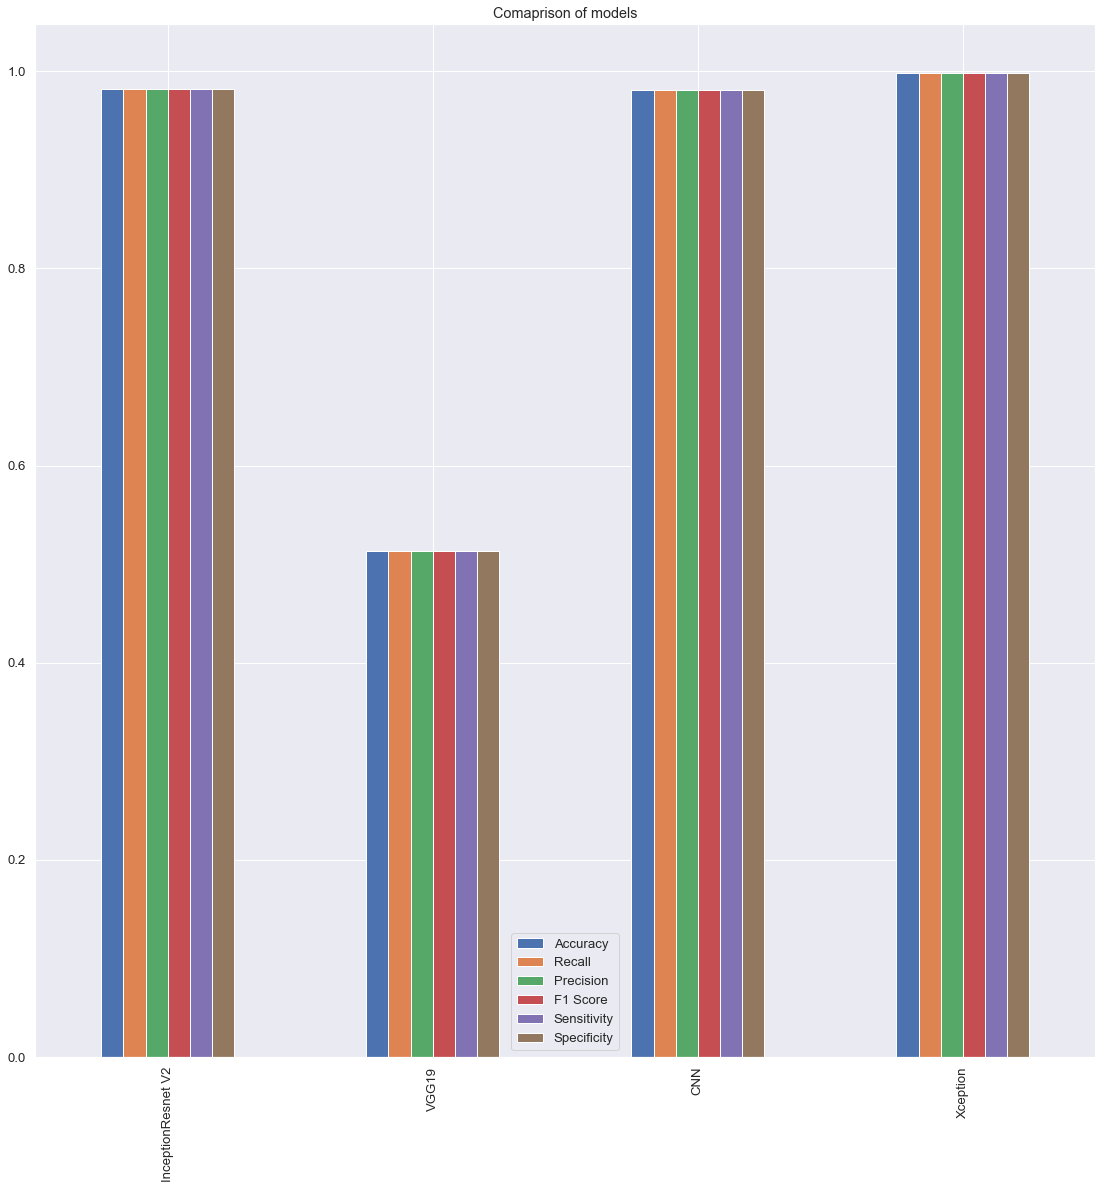

In [45]:
fig =results.plot(kind='bar',title='Comaprison of models',figsize =(19,19)).get_figure()
fig.savefig('Final Result.png')

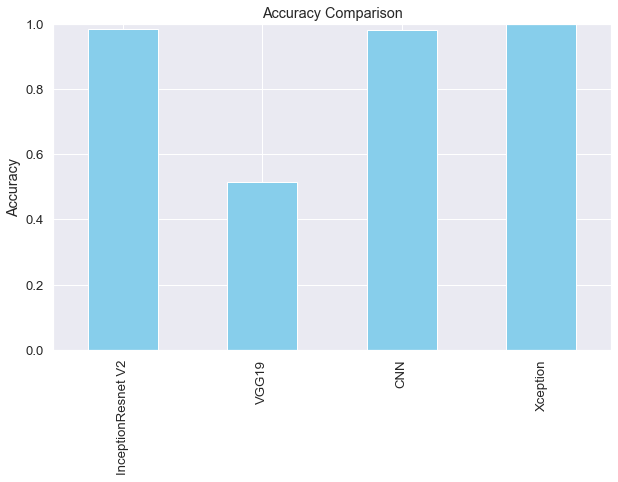

In [46]:
results_df = pd.DataFrame(results, index=['InceptionResnet V2', 'VGG19', 'CNN', 'Xception'])

# Plotting Accuracy
plt.figure(figsize=(10, 6))
results_df['Accuracy'].plot(kind='bar', color='skyblue')
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

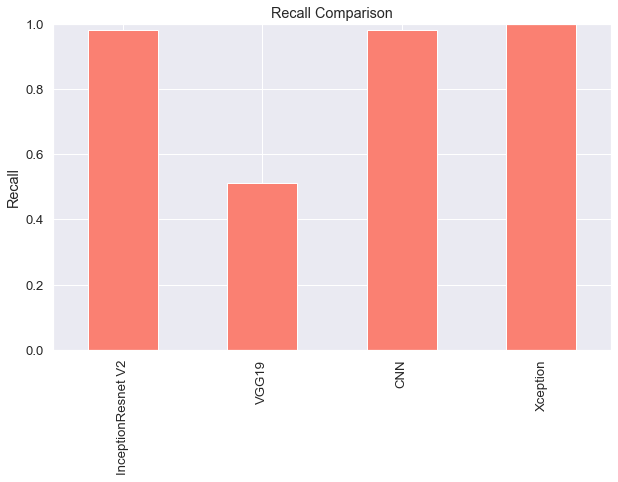

In [47]:
plt.figure(figsize=(10, 6))
results_df['Recall'].plot(kind='bar', color='salmon')
plt.title('Recall Comparison')
plt.ylabel('Recall')
plt.ylim(0, 1)
plt.show()

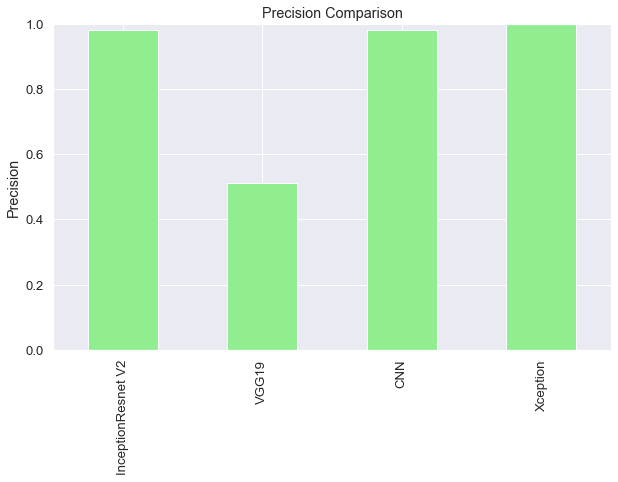

In [48]:
plt.figure(figsize=(10, 6))
results_df['Precision'].plot(kind='bar', color='lightgreen')
plt.title('Precision Comparison')
plt.ylabel('Precision')
plt.ylim(0, 1)
plt.show()

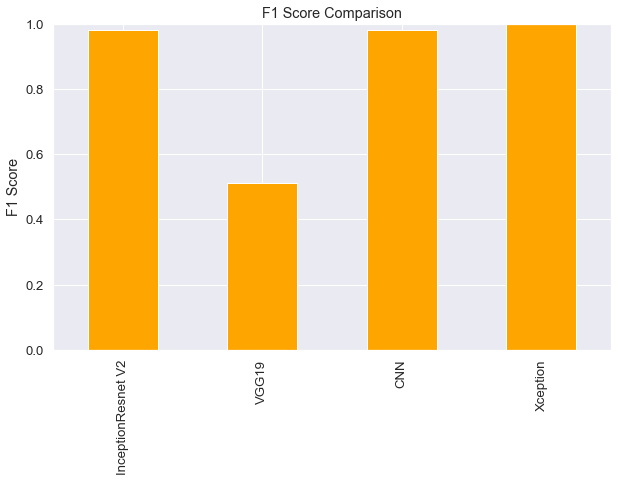

In [49]:
plt.figure(figsize=(10, 6))
results_df['F1 Score'].plot(kind='bar', color='orange')
plt.title('F1 Score Comparison')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.show()

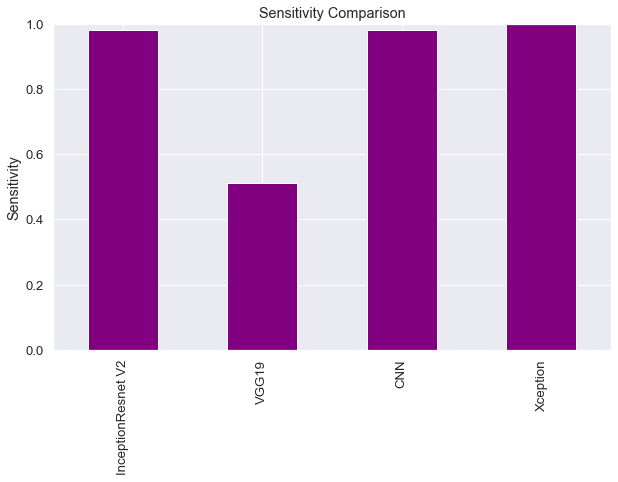

In [50]:
plt.figure(figsize=(10, 6))
results_df['Sensitivity'].plot(kind='bar', color='purple')
plt.title('Sensitivity Comparison')
plt.ylabel('Sensitivity')
plt.ylim(0, 1)
plt.show()

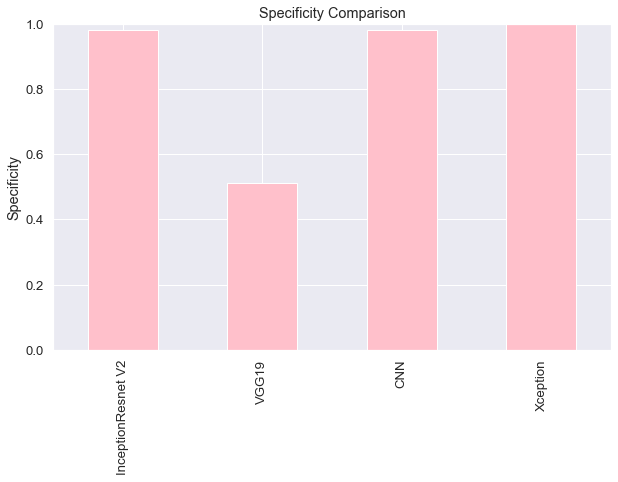

In [51]:
plt.figure(figsize=(10, 6))
results_df['Specificity'].plot(kind='bar', color='pink')
plt.title('Specificity Comparison')
plt.ylabel('Specificity')
plt.ylim(0, 1)
plt.show()